In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf



2022-02-08 16:36:52.246333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-08 16:36:52.246432: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def create_dataset():
    directory = "../../processed_data/train_set/"
    data= []
    label= []
    for i in range(1, 7):
        for filename in os.listdir(directory+str(i)):
            if filename.endswith(".png"):
                img = Image.open(directory+str(i)+"/"+filename)
                data.append(np.array(img))
                label.append(i-1)
            if len(data)% 100 ==0:
                break
    print(len(data))
    return data, label

In [3]:
data, labels= create_dataset() 

600


In [4]:
data = np.array(data)
data.shape

(600, 128, 128)

In [5]:
preprocessed_data = data/255
labels= np.array(labels).reshape(-1,1)

In [6]:
print("Drawings shape before : ", preprocessed_data.shape)
preprocessed_data = np.expand_dims(preprocessed_data, axis=3)
print("Drawings shape after : ", preprocessed_data.shape)
print("Label shape : ", labels.shape)

Drawings shape before :  (600, 128, 128)
Drawings shape after :  (600, 128, 128, 1)
Label shape :  (600, 1)


In [7]:
from sklearn.model_selection import train_test_split

# split data in train/val/test set
train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    preprocessed_data, 
    labels,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_val_data, 
    train_val_labels,
    test_size=0.3, 
    random_state=42, 
    shuffle=True
)

In [8]:
def SSIMLoss(y_true, y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [9]:
inputs = tf.keras.Input(shape=(128, 128, 1), name='input_layer')


In [10]:
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.MaxPool2D(strides= 2)(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

2022-02-08 16:37:23.715567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-08 16:37:23.715705: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-08 16:37:23.715794: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (venkys-pc): /proc/driver/nvidia/version does not exist
2022-02-08 16:37:23.716768: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.Conv2DTranspose(32, 3, strides= 2, padding='same',name='conv_transpose_2')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

In [12]:
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)


In [13]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

/home/admin1/anaconda3/envs/pytorch/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 64, 64, 32)       9248      
 nspose)                                                         
                                                                 
 conv_transpose_2 (Conv2DTra  (None, 128, 128, 32)     9248      
 nspose)                                                         
                                                             

In [15]:
# dot_img_file = '../assets/autoencoder.png'
# tf.keras.utils.plot_model(autoencoder, to_file=dot_img_file, show_shapes=True)

In [16]:
!rm -rf ./logs/


In [17]:
from keras.callbacks import TensorBoard


In [18]:
hist=autoencoder.fit(train_val_data, train_val_data,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data), callbacks=[TensorBoard(log_dir='logs/')])

Epoch 1/5
4/4 [==============================] - 52s 12s/step - loss: 0.7028 - val_loss: 0.5521
Epoch 2/5
4/4 [==============================] - 50s 13s/step - loss: 0.4937 - val_loss: 0.4537
Epoch 3/5
4/4 [==============================] - 50s 13s/step - loss: 0.4786 - val_loss: 0.4858
Epoch 4/5
4/4 [==============================] - 47s 12s/step - loss: 0.4738 - val_loss: 0.4340
Epoch 5/5
4/4 [==============================] - 49s 12s/step - loss: 0.4297 - val_loss: 0.4214


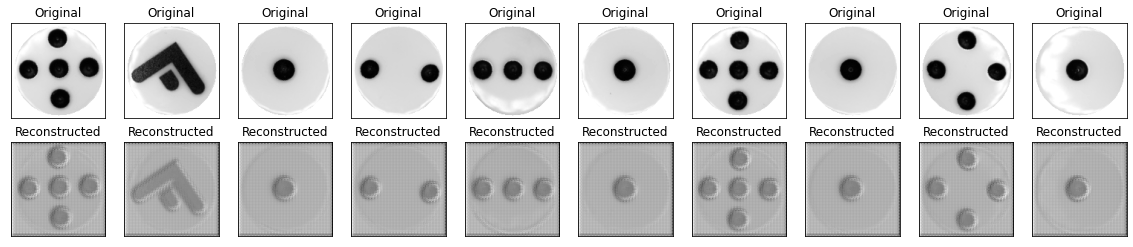

In [19]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
def create_dataset_ano():
    directory = "../../processed_data/train_set/ano"
    data= []
    label= []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img = Image.open(directory+"/"+filename)
            data.append(np.array(img))
                
    print(len(data))
    return data

In [21]:
anomalies = create_dataset_ano()


56


In [22]:
anomalies = np.array(anomalies)

In [23]:
anomalies.shape


(56, 128, 128)

In [24]:
anomalies = np.expand_dims(anomalies,axis=3)

In [25]:
anomalies.shape

(56, 128, 128, 1)

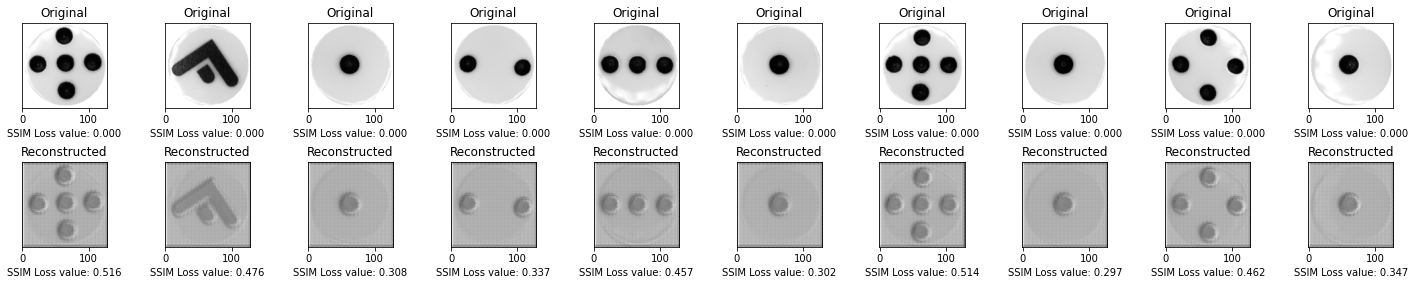

In [26]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a))
plt.tight_layout()
plt.show()

In [27]:
anomalies = anomalies/255

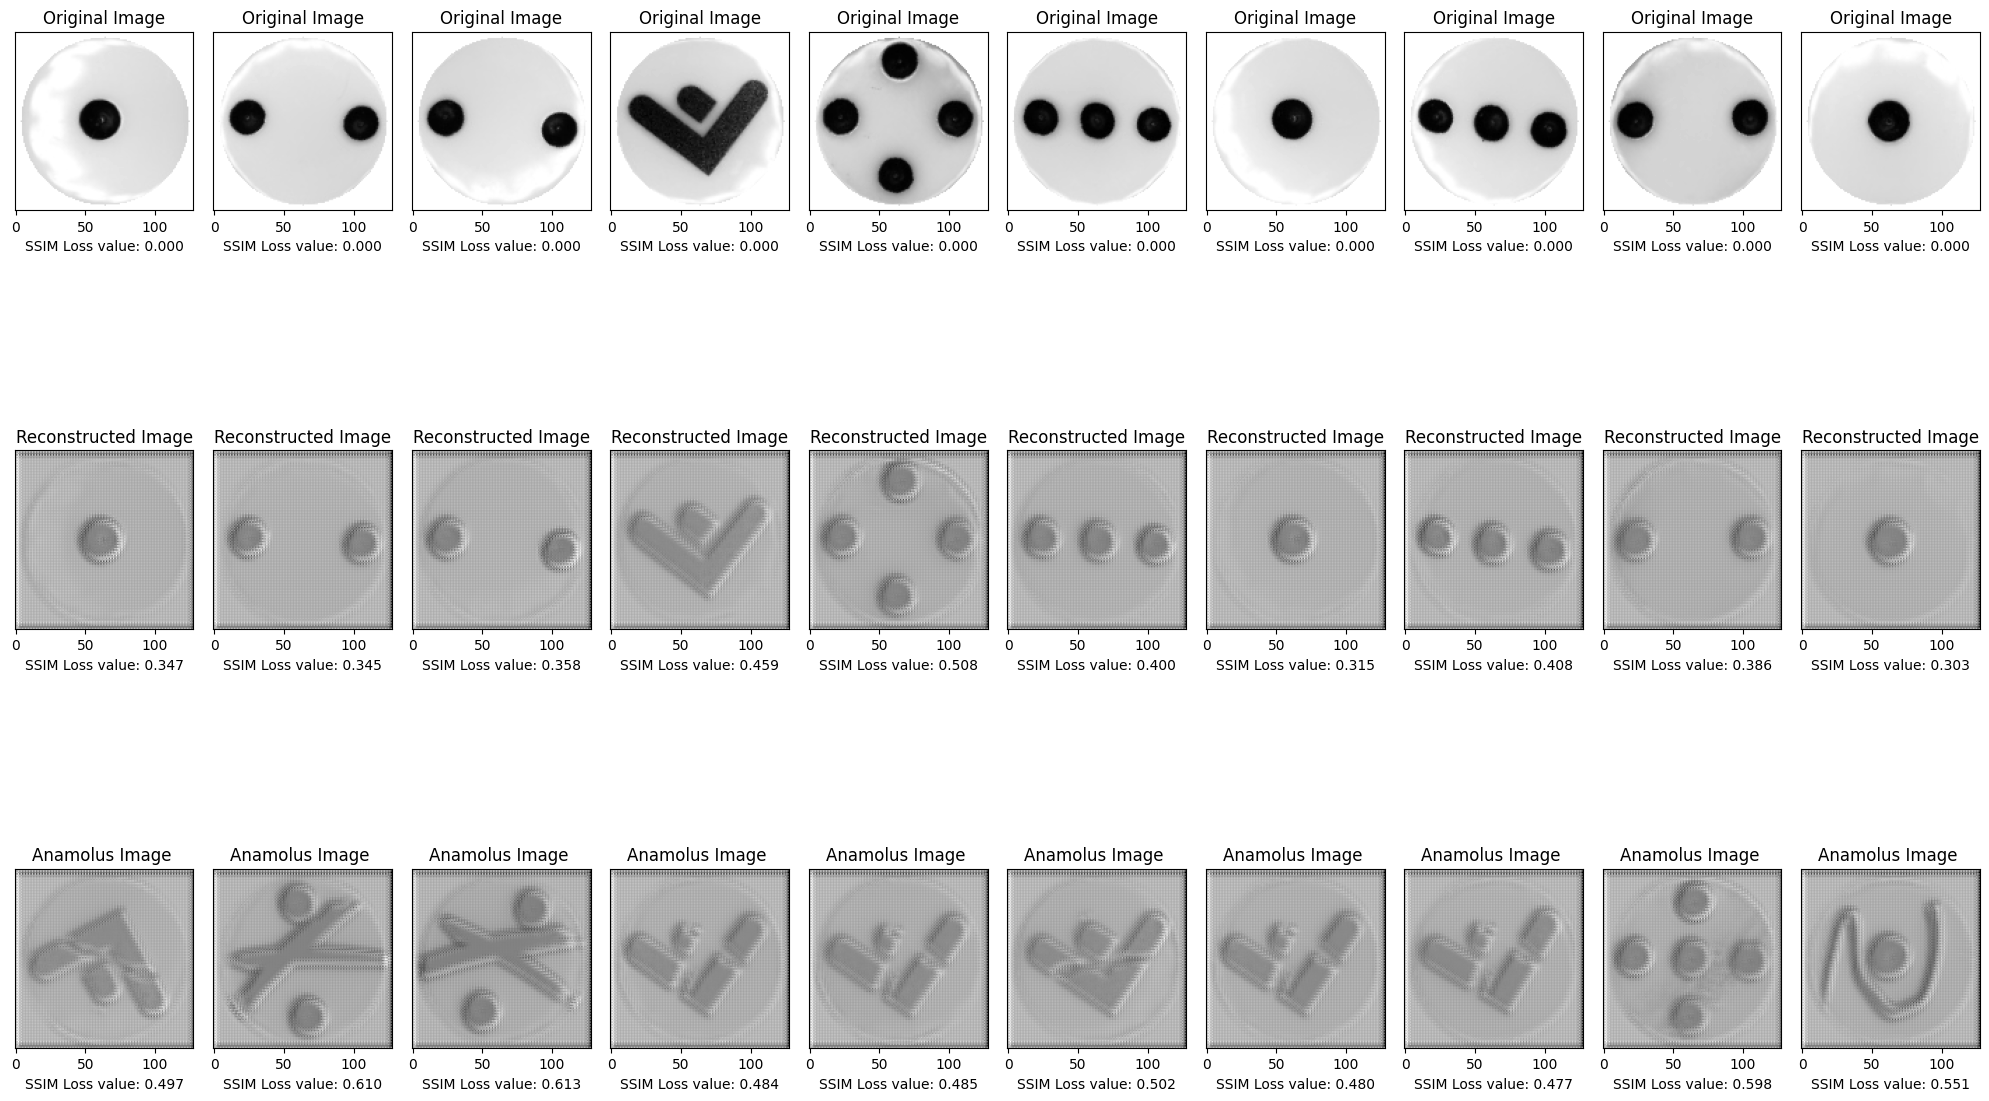

In [28]:
%matplotlib inline
n = 10 # how many encoded and decoded images we will display
decoded_imgs= autoencoder.predict(test_data)

decoded_mnistimgs= autoencoder.predict(anomalies)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n, n+10):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(anomalies[i], decoded_mnistimgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.tight_layout()
plt.show()

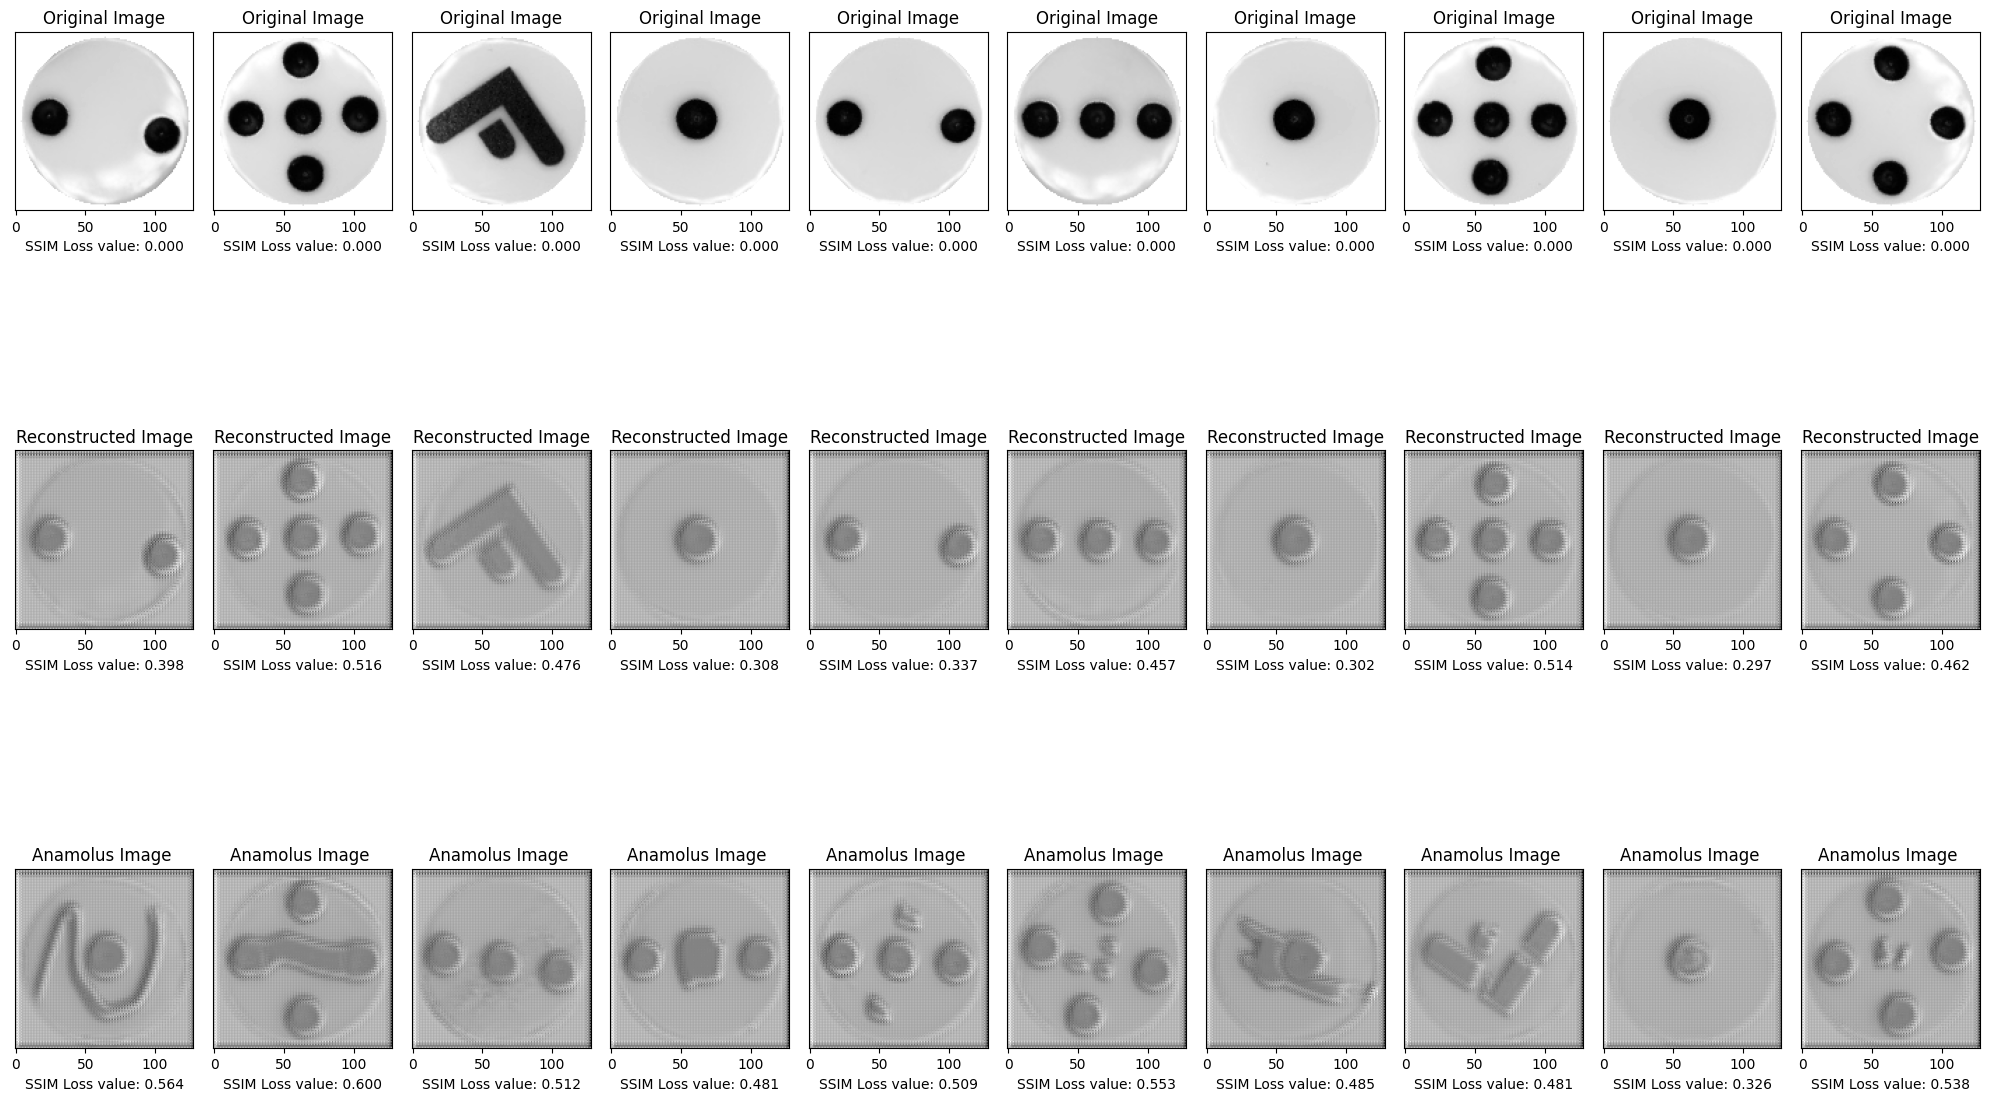

In [29]:
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(anomalies[i], decoded_mnistimgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.tight_layout()
plt.show()

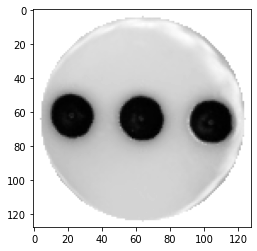

In [30]:
img = Image.open("../../processed_data/train_set/3/16_09_21_03_000.png")
plt.imshow(img, cmap="gray")
img = np.array(img)/255
decoded_imgs= autoencoder.predict(np.array([img.reshape(128, 128, 1)]))

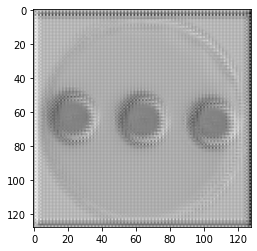

In [31]:
plt.imshow(decoded_imgs[0])

In [32]:
test_data.shape

(120, 128, 128, 1)

In [33]:
np.array([np.array(img).reshape(128, 128, 1)]).shape

(1, 128, 128, 1)